In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_anthropic langchain_openai

In [2]:
# subgraphs

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph


def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


child_builder = StateGraph(ChildState)

child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
child_builder.set_entry_point("child_start")
child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})
child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})
child_builder.add_edge("child_start", "child_middle")
child_builder.add_edge("child_middle", "child_end")
child_builder.set_finish_point("child_end")

builder = StateGraph(ParentState)

builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
builder.set_entry_point("grandparent")
builder.add_node("parent", lambda state: {"path": ["parent"]})
builder.add_node("child", child_builder.compile())
builder.add_node("sibling", lambda state: {"path": ["sibling"]})
builder.add_node("fin", lambda state: {"path": ["fin"]})

# Add connections
builder.add_edge("grandparent", "parent")
builder.add_edge("parent", "child")
builder.add_edge("parent", "sibling")
builder.add_edge("child", "fin")
builder.add_edge("sibling", "fin")
builder.set_finish_point("fin")
graph = builder.compile()

In [3]:
graph.invoke({"name": "test"}, debug=True)

[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test', 'path': ['grandparent']}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[3:tasks] Starting step 3 with 2 tasks:
- child -> {'name': 'test', 'path': ['grandparent', 'parent']}
- sibling -> {'name': 'test', 'path': ['grandparent', 'parent']}
[3:writes] Finished step 3 with writes to 2 channels:
- name -> 'test'
- path -> ['grandparent', 'parent', 'child_start', 'child_middle', 'child_end'], ['sibling']
[4:tasks] Starting step 4 with 1 task:
- fin -> {'name': 'test',
 'path': ['grandparent',
          'parent',
          'grandparent',
          'parent',
          'child_start',
          'child

{'name': 'test',
 'path': ['grandparent',
  'parent',
  'grandparent',
  'parent',
  'child_start',
  'child_middle',
  'child_end',
  'sibling',
  'fin']}

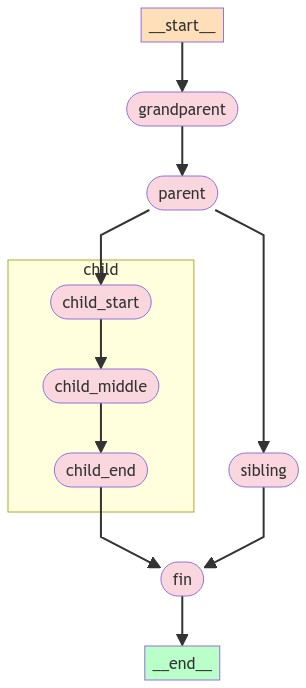

In [4]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)

# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [6]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")



In [7]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [8]:
from langchain_core.tools import tool
from langchain_core.messages import AIMessage


llm = ChatOpenAI(model="gpt-4-1106-preview")

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # print(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        # print(result)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

@tool
def mock_tool(message: str, recipient: str) -> str:
    "Send an email to person x"
    return f"Successfully sent email to {recipient}."

import functools
tools = [mock_tool]
# Research agent and node
research_agent = create_agent(
    llm,
    tools,
    system_message="your job is to provide fake research about an issue, you can make it up",
)
joke_agent = create_agent(
    llm,
    tools,
    system_message="you are a comedian and make a sarcastic joke about the input you get, also give your input first",
)

research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")
joke_node = functools.partial(agent_node, agent=joke_agent, name="Joke Agent")

In [9]:
workflow = StateGraph(AgentState)
workflow.add_node('researcher', research_node)
workflow.add_node('joke_agent',joke_node)
workflow.add_edge('researcher','joke_agent')

In [10]:
workflow.set_entry_point("researcher")
workflow.set_finish_point("joke_agent")
graph = workflow.compile()

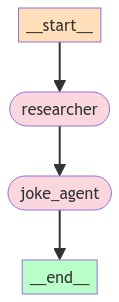

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="we are developing a joke based upon research about dancing"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 10},
)
for details in events:
    if isinstance(details, dict):
        events_list = list(details.values())
    else:
        events_list = list(details)

    for details in events_list:
        print(details['sender'])
        for message in details['messages']:
            print(f"Message: {message.content}")

Researcher
Message: To develop a joke based on fake research about dancing, we could concoct a humorous study result that plays on the expectations people might have regarding dancing. Here's an example of a fake research finding that could be the punchline of our joke:

"After a comprehensive study involving thousands of participants, researchers have discovered that dancing backwards is not only more difficult but has been found to reverse the aging process. Participants reported feeling younger with every step taken in reverse, with some even forgetting why they entered the room in the first place."

Now, let's turn this fake research finding into a joke:

"Why are all the scientists at the dance studio walking backwards? Because they found that it's not only a step back in dance technique but also a leap forward in anti-aging!"

This joke plays with the absurdity of the fake research findings and creates a comical image of scientists earnestly trying to reverse aging by dancing bac